Setup: import libraries, load project modules, and initialize a Spark session.

In [1]:
import sys
import os

# Set up the path to include the src directory
sys.path.append(os.path.abspath('..'))


%load_ext autoreload
%autoreload 2

# Set HADOOP_HOME to the folder CONTAINING the bin folder
os.environ["HADOOP_HOME"] = "C:\\hadoop" 
# Add the bin folder to the system PATH
sys.path.append("C:\\hadoop\\bin")

# Data Export
import json
import os

# Define export paths (relative to the notebook location)
raw_path = "../data/raw/movies_raw.json"
processed_path = "../data/processed/movies_processed.csv"

# Ensure the directories exist
os.makedirs(os.path.dirname(raw_path), exist_ok=True)
os.makedirs(os.path.dirname(processed_path), exist_ok=True)

# Import our custom modules
from src.utils import get_spark_session
from src.extraction.config import API_KEY, BASE_URL, MOVIE_IDS, CREDITS_STRUCT
from src.extraction.fetch import fetch_movie_data
from src.extraction.config import RAW_SCHEMA
# from src.transform.cleaning import clean_movie_data
from src.transform.cleaning import MovieTransformer
# from src.transform.analysis import get_ranked_movies, analyze_franchises, get_franchise_comparison, get_top_performing_franchises
from src.transform.analysis import MovieAnalyzer
from src.visualization.visualization import (
    plot_yearly_trends, 
    plot_genre_roi, 
    plot_revenue_vs_budget, 
    plot_franchise_comparison, 
    plot_popularity_vs_rating
)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark
spark = get_spark_session("TMDB_Analysis_Lab")
print(f"Spark Version: {spark.version}")

Spark Version: 3.5.0


# Project Steps

### Step 1: Fetch Movie Data from API
Data ingestion: fetch movie JSON from TMDB and create a Spark DataFrame with the enforced schema.

In [ ]:
# 1. Fetch raw data using Python (Driver Node)
print(f"Fetching data for {len(MOVIE_IDS)} movies...")
raw_data_list = fetch_movie_data(MOVIE_IDS, API_KEY, BASE_URL) # type: ignore

2026-01-26 07:39:53,324 - INFO - Fetching ID 0 (Attempt 1/3)...


Fetching data for 19 movies...


2026-01-26 07:39:54,568 - WARNING - Movie ID 0 not found (404). Skipping.
2026-01-26 07:39:54,772 - INFO - Fetching ID 299534 (Attempt 1/3)...
2026-01-26 07:39:55,275 - INFO - Fetching ID 19995 (Attempt 1/3)...
2026-01-26 07:39:55,801 - INFO - Fetching ID 140607 (Attempt 1/3)...
2026-01-26 07:39:56,278 - INFO - Fetching ID 299536 (Attempt 1/3)...
2026-01-26 07:39:56,790 - INFO - Fetching ID 597 (Attempt 1/3)...
2026-01-26 07:39:57,259 - INFO - Fetching ID 135397 (Attempt 1/3)...
2026-01-26 07:39:57,736 - INFO - Fetching ID 420818 (Attempt 1/3)...
2026-01-26 07:39:58,185 - INFO - Fetching ID 24428 (Attempt 1/3)...
2026-01-26 07:39:58,692 - INFO - Fetching ID 168259 (Attempt 1/3)...
2026-01-26 07:39:59,168 - INFO - Fetching ID 99861 (Attempt 1/3)...
2026-01-26 07:39:59,674 - INFO - Fetching ID 284054 (Attempt 1/3)...
2026-01-26 07:40:00,180 - INFO - Fetching ID 12445 (Attempt 1/3)...
2026-01-26 07:40:00,644 - INFO - Fetching ID 181808 (Attempt 1/3)...
2026-01-26 07:40:01,112 - INFO - Fet

In [3]:
# 2. Convert to Spark DataFrame ENFORCING the schema
# This prevents Spark from guessing "Map" instead of "Struct"
df_raw = spark.createDataFrame(raw_data_list, schema=RAW_SCHEMA)

print("Raw Schema:")
df_raw.printSchema()

Raw Schema:
root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- budget: long (nullable = true)
 |-- runtime: long (nullable = true)
 |-- popularity: double (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: long (nullable = true)
 |-- original_language: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- credits: struct (nullable = true)
 |    |-- cast: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: integer (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |-- crew: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: integer (nullable = true)
 |    |    |    |-- name: string (nullable = true

### Step 2: Data Cleaning and Preprocessing
Cleaning: run the Spark cleaning pipeline to normalize fields and compute derived metrics.

In [4]:
# Initialize the modular transformer
transformer = MovieTransformer()

# Execute the pipeline
df_clean = transformer.run_pipeline(df_raw)

# Save results
df_clean.write.mode("overwrite").csv("data/processed/movies_processed")

2026-01-26 07:40:06,430 - INFO - Starting Movie Data Transformation Pipeline...
2026-01-26 07:40:06,430 - INFO - Dropping 5 irrelevant columns.
2026-01-26 07:40:06,499 - INFO - Schema before nested json handling: struct<id:bigint,title:string,overview:string,tagline:string,status:string,release_date:string,revenue:bigint,budget:bigint,runtime:bigint,popularity:double,vote_average:double,vote_count:bigint,original_language:string,poster_path:string,credits:struct<cast:array<struct<id:int,name:string>>,crew:array<struct<id:int,name:string,job:string>>>,belongs_to_collection:struct<id:int,name:string,poster_path:string,backdrop_path:string>,genres:array<struct<id:int,name:string>>,production_companies:array<struct<name:string,id:int,logo_path:string,origin_country:string>>,production_countries:array<struct<iso_3166_1:string,name:string>>,spoken_languages:array<struct<iso_639_1:string,name:string,english_name:string>>>
2026-01-26 07:40:07,034 - INFO - Nested JSON structures flattened and j

In [5]:
print(f"Cleaned Row Count: {df_clean.count()}")
df_clean.select("title", "release_date", "revenue_musd", "roi").show(5, truncate=False)

Cleaned Row Count: 18
+----------------------------+------------+------------+-----------------+
|title                       |release_date|revenue_musd|roi              |
+----------------------------+------------+------------+-----------------+
|Avengers: Endgame           |2019-04-24  |2799.4391   |7.86359297752809 |
|Avatar                      |2009-12-16  |2923.706026 |12.33631234599156|
|Star Wars: The Force Awakens|2015-12-15  |2068.223624 |8.441729077551022|
|Avengers: Infinity War      |2018-04-25  |2052.415039 |6.841383463333333|
|Titanic                     |1997-12-18  |2264.162353 |11.320811765     |
+----------------------------+------------+------------+-----------------+
only showing top 5 rows



Export: write raw JSON and processed CSV to the `data/` directories.

In [6]:
# Export Raw Data (JSON)
try:
    with open(raw_path, 'w') as f:
        json.dump(raw_data_list, f, indent=4)
    print(f"SUCCESS: Raw data saved to {raw_path}")
except Exception as e:
    print(f"ERROR: Could not save raw JSON. {e}")

# 2. Export Processed Data (CSV)
try:
    df_clean.toPandas().to_csv(processed_path, index=False)
    print(f"SUCCESS: Processed data saved to {processed_path}")
except Exception as e:
    print(f"ERROR: Could not save processed CSV. {e}")

SUCCESS: Raw data saved to ../data/raw/movies_raw.json
SUCCESS: Processed data saved to ../data/processed/movies_processed.csv


### Step 3: KPI Implementation & Analysis
1. Filter and rank movies

In [7]:
print("--- Top 5 Highest Revenue ---")
top_rev = MovieAnalyzer(spark_df=df_clean).get_ranked_movies("revenue_musd", ascending=False)
top_rev.select("title", "revenue_musd", "budget_musd").show()

2026-01-26 07:40:48,233 - INFO - Ranking top 5 movies by revenue_musd (Spark)


--- Top 5 Highest Revenue ---
+--------------------+------------+-----------+
|               title|revenue_musd|budget_musd|
+--------------------+------------+-----------+
|              Avatar| 2923.706026|      237.0|
|   Avengers: Endgame|   2799.4391|      356.0|
|             Titanic| 2264.162353|      200.0|
|Star Wars: The Fo...| 2068.223624|      245.0|
|Avengers: Infinit...| 2052.415039|      300.0|
+--------------------+------------+-----------+



In [8]:
print("--- Highest Budget Movies ---")  
top_budget = MovieAnalyzer(spark_df=df_clean).get_ranked_movies("budget_musd", ascending=False)
top_budget.select("title", "budget_musd", "revenue_musd").show()

2026-01-26 07:40:56,980 - INFO - Ranking top 5 movies by budget_musd (Spark)


--- Highest Budget Movies ---
+--------------------+-----------+------------+
|               title|budget_musd|revenue_musd|
+--------------------+-----------+------------+
|   Avengers: Endgame|      356.0|   2799.4391|
|Star Wars: The La...|      300.0|  1332.69883|
|Avengers: Infinit...|      300.0| 2052.415039|
|       The Lion King|      260.0| 1662.020819|
|Star Wars: The Fo...|      245.0| 2068.223624|
+--------------------+-----------+------------+



In [9]:
print("--- Highest Profit (revenue - budget) ---")
top_profit = MovieAnalyzer(spark_df=df_clean).get_ranked_movies("profit", ascending=False)
top_profit.select("title", "profit", "budget_musd", "revenue_musd").show()

--- Highest Profit (revenue - budget) ---


2026-01-26 07:41:05,913 - INFO - Ranking top 5 movies by profit (Spark)


+--------------------+------------------+-----------+------------+
|               title|            profit|budget_musd|revenue_musd|
+--------------------+------------------+-----------+------------+
|              Avatar|       2686.706026|      237.0| 2923.706026|
|   Avengers: Endgame|         2443.4391|      356.0|   2799.4391|
|             Titanic|       2064.162353|      200.0| 2264.162353|
|Star Wars: The Fo...|1823.2236240000002|      245.0| 2068.223624|
|Avengers: Infinit...|       1752.415039|      300.0| 2052.415039|
+--------------------+------------------+-----------+------------+



In [10]:
print("--- Lowest profit (revenue - budget) ---")
low_profit = MovieAnalyzer(spark_df=df_clean).get_ranked_movies("profit", ascending=True)
low_profit.select("title", "profit", "budget_musd", "revenue_musd").show()

2026-01-26 07:41:15,414 - INFO - Ranking top 5 movies by profit (Spark)


--- Lowest profit (revenue - budget) ---
+--------------------+-----------+-----------+------------+
|               title|     profit|budget_musd|revenue_musd|
+--------------------+-----------+-----------+------------+
|Star Wars: The La...| 1032.69883|      300.0|  1332.69883|
|       Incredibles 2|1043.225667|      200.0| 1243.225667|
|Beauty and the Beast|1106.115964|      160.0| 1266.115964|
|              Frozen|1124.219009|      150.0| 1274.219009|
|Jurassic World: F...|1140.469037|      170.0| 1310.469037|
+--------------------+-----------+-----------+------------+



In [11]:
print("--- Top 5 Highest ROI ---")
top_roi = MovieAnalyzer(spark_df=df_clean).get_ranked_movies("roi", ascending=False)
top_roi.select("title", "roi", "revenue_musd").show()

2026-01-26 07:41:25,379 - INFO - Ranking top 5 movies by roi (Spark)


--- Top 5 Highest ROI ---
+--------------------+-----------------+------------+
|               title|              roi|revenue_musd|
+--------------------+-----------------+------------+
|              Avatar|12.33631234599156| 2923.706026|
|             Titanic|     11.320811765| 2264.162353|
|      Jurassic World|      11.14358296| 1671.537444|
|Harry Potter and ...|     10.732089752| 1341.511219|
|           Frozen II|9.691223173333332| 1453.683476|
+--------------------+-----------------+------------+



In [12]:
print("--- Lowest ROI (revenue/budget only movies with budget >= 10) ---")
# Filter for significant budget first to avoid divide-by-zero anomalies on micro-films
flop_roi = MovieAnalyzer(spark_df=df_clean.filter("budget_musd >= 10")).get_ranked_movies("roi", ascending=True)
flop_roi.select("title", "roi", "budget_musd", "revenue_musd").show()

2026-01-26 07:41:35,118 - INFO - Ranking top 5 movies by roi (Spark)


--- Lowest ROI (revenue/budget only movies with budget >= 10) ---
+--------------------+------------------+-----------+------------+
|               title|               roi|budget_musd|revenue_musd|
+--------------------+------------------+-----------+------------+
|Star Wars: The La...| 4.442329433333334|      300.0|  1332.69883|
|Avengers: Age of ...|  5.98044125106383|      235.0| 1405.403694|
|       Incredibles 2|       6.216128335|      200.0| 1243.225667|
|       The Lion King|6.3923877653846155|      260.0| 1662.020819|
|       Black Panther|       6.749630415|      200.0| 1349.926083|
+--------------------+------------------+-----------+------------+



In [13]:
print("--- Most Voted movies ---")
top_votes = MovieAnalyzer(spark_df=df_clean).get_ranked_movies("vote_count", ascending=False)
top_votes.select("title", "vote_count").show()

--- Most Voted movies ---


2026-01-26 07:41:44,470 - INFO - Ranking top 5 movies by vote_count (Spark)


+--------------------+----------+
|               title|vote_count|
+--------------------+----------+
|        The Avengers|     35391|
|              Avatar|     33326|
|Avengers: Infinit...|     31385|
|   Avengers: Endgame|     27170|
|             Titanic|     26702|
+--------------------+----------+



In [14]:
print("--- Highest Raated Movies (only movies with >= 10 votes) ---")
top_rated = MovieAnalyzer(spark_df=df_clean.filter("vote_count >= 10")).get_ranked_movies("vote_average", ascending=False)
top_rated.select("title", "vote_average", "vote_count").show()

--- Highest Raated Movies (only movies with >= 10 votes) ---

2026-01-26 07:41:53,443 - INFO - Ranking top 5 movies by vote_average (Spark)



+--------------------+------------+----------+
|               title|vote_average|vote_count|
+--------------------+------------+----------+
|Avengers: Infinit...|       8.235|     31385|
|   Avengers: Endgame|         8.2|     27170|
|Harry Potter and ...|       8.081|     21607|
|        The Avengers|       7.919|     35391|
|             Titanic|       7.902|     26702|
+--------------------+------------+----------+



In [15]:
print("--- Lowest Rated movies (only movies with >= 10 votes) ---")
low_rated = MovieAnalyzer(spark_df=df_clean.filter("vote_count >= 10")).get_ranked_movies("vote_average", ascending=True)
low_rated.select("title", "vote_average", "vote_count").show()

2026-01-26 07:42:02,997 - INFO - Ranking top 5 movies by vote_average (Spark)


--- Lowest Rated movies (only movies with >= 10 votes) ---
+--------------------+------------+----------+
|               title|vote_average|vote_count|
+--------------------+------------+----------+
|Jurassic World: F...|       6.535|     12506|
|      Jurassic World|         6.7|     21254|
|Star Wars: The La...|        6.76|     16045|
|Beauty and the Beast|       6.968|     15885|
|       The Lion King|       7.097|     10617|
+--------------------+------------+----------+



In [16]:
print("--- Most Popular Movies ---")
top_popular = MovieAnalyzer(spark_df=df_clean).get_ranked_movies("popularity", ascending=False)
top_popular.select("title", "popularity").show()

2026-01-26 07:42:11,329 - INFO - Ranking top 5 movies by popularity (Spark)


--- Most Popular Movies ---
+--------------------+----------+
|               title|popularity|
+--------------------+----------+
|        The Avengers|   82.8271|
|              Avatar|   48.9819|
|Avengers: Infinit...|     31.32|
|             Titanic|    30.564|
|              Frozen|   21.0553|
+--------------------+----------+



Advanced Movie Filtering & Search Queries

2. Filter the dataset for specific queries

In [17]:
print("--- Search 1: Best-rated Science Fiction Action movies starring Bruce Willis (sorted by Rating - highest to lowest).")
# Filter for Science Fiction Action movies starring Bruce Willis
filtered_movies = df_clean.filter("genres like '%Action%' and genres like '%Science Fiction%' and cast like '%Bruce Willis%'")
# Sort by vote_average descending
best_rated = MovieAnalyzer(spark_df=filtered_movies).get_ranked_movies("vote_average", ascending=False)
best_rated.select("title", "vote_average").show()

2026-01-26 07:42:19,884 - INFO - Ranking top 5 movies by vote_average (Spark)


--- Search 1: Best-rated Science Fiction Action movies starring Bruce Willis (sorted by Rating - highest to lowest).
+-----+------------+
|title|vote_average|
+-----+------------+
+-----+------------+



In [18]:
print("--- Search 2: movies starring Uma Thurman, directed by Quentin Tarantino (sorted by runtime - shortest to longest).")
# Filter for movies starring Uma Thurman and directed by Quentin Tarantino
filtered_movies = df_clean.filter("cast like '%Uma Thurman%' and director like '%Quentin Tarantino%'")
# Sort by runtime ascending
shortest_runtime = MovieAnalyzer(spark_df=filtered_movies).get_ranked_movies("runtime", ascending=True)
shortest_runtime.select("title", "runtime").show()

2026-01-26 07:42:31,354 - INFO - Ranking top 5 movies by runtime (Spark)


--- Search 2: movies starring Uma Thurman, directed by Quentin Tarantino (sorted by runtime - shortest to longest).
+-----+-------+
|title|runtime|
+-----+-------+
+-----+-------+



In [19]:
# Compare Franchises vs Standalone
franchise_stats = MovieAnalyzer(spark_df=df_clean).analyze_franchises()

# Collect to Pandas for display
pdf_franchise = franchise_stats.toPandas()
display(pdf_franchise)

2026-01-26 07:42:40,296 - INFO - Analyzing franchise statistics (Spark)


,is_franchise,count,avg_revenue,median_roi,avg_budget,avg_popularity,avg_rating
0,True,16,1682.668411,7.786117,218.0,21.621681,7.387437
1,False,2,1765.139159,9.617018,180.0,24.708000,7.435000


Franchise vs. Standalone Movie Performance

3. Compare movie franchises (belongs_to_collection) vs. standalone movies

In [20]:
# Initialize
analyzer = MovieAnalyzer(spark_df=df_clean, pandas_df=df_clean.toPandas())

# 1. Ranking: Find 5 biggest financial "flops" (lowest ROI)
print("Lowest ROI Movies:")
analyzer.get_ranked_movies(metric='roi', ascending=True, limit=5).show()

2026-01-26 07:42:58,048 - INFO - Ranking top 5 movies by roi (Spark)


Lowest ROI Movies:
+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------------+--------------------+--------------------+--------------------+------------+-----------+------------------+
|    id|               title|             tagline|release_date|              genres|belongs_to_collection|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|          spoken_languages|         poster_path|                cast|                crew|    director|     profit|               roi|
+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------

Most Successful Franchises & Directors

4. Find the Most Successful Movie Franchises based on:

In [21]:
# 2. Franchise Report
print("Franchise vs Standalone Performance:")
display(analyzer.get_franchise_comparison())

2026-01-26 07:43:06,972 - INFO - Logging Franchise comparison report


Franchise vs Standalone Performance:


,revenue_musd,roi,budget_musd,popularity,vote_average,movie_count
is_franchise,,,,,,
Standalone,1765.14,9.62,180.0,24.71,7.44,2
Franchise,1682.67,7.79,218.0,21.62,7.39,16


In [22]:
print("Top 10 Most Successful Movie Franchises:")
franchise_report = analyzer.get_detailed_franchise_success(n=10)
display(franchise_report)

2026-01-26 07:43:07,187 - INFO - Logging detailed success report for top 10 franchises.


Top 10 Most Successful Movie Franchises:


,movie_count,total_budget_musd,mean_budget_musd,total_revenue_musd,mean_revenue_musd,mean_rating
belongs_to_collection,,,,,,
The Avengers Collection,4,1111.0,277.75,7776.07,1944.02,7.91
Star Wars Collection,2,545.0,272.50,3400.92,1700.46,7.01
Jurassic Park Collection,2,320.0,160.00,2982.01,1491.00,6.62
Avatar Collection,1,237.0,237.00,2923.71,2923.71,7.60
Frozen Collection,2,300.0,150.00,2727.90,1363.95,7.24
The Lion King (Reboot) Collection,1,260.0,260.00,1662.02,1662.02,7.10
The Fast and the Furious Collection,1,190.0,190.00,1515.40,1515.40,7.22
Black Panther Collection,1,200.0,200.00,1349.93,1349.93,7.36
Harry Potter Collection,1,125.0,125.00,1341.51,1341.51,8.08


5. Find the Most Successful Directors

In [23]:
# 5. Find Most Successful Directors
print("Top 10 Most Successful Directors by Total Revenue:")
director_report = analyzer.get_most_successful_directors(n=10)
display(director_report)

Top 10 Most Successful Directors by Total Revenue:

2026-01-26 07:43:07,377 - INFO - Analyzing success for the top 10 directors.


,movies_directed,total_revenue_musd,mean_rating
director,,,
James Cameron,2,5187.87,7.75
Joss Whedon,2,2924.22,7.61
Joe Russo,1,2799.44,8.20
Jennifer Lee,2,2727.90,7.24
J.J. Abrams,1,2068.22,7.25
Anthony Russo,1,2052.42,8.24
Colin Trevorrow,1,1671.54,6.70
Jon Favreau,1,1662.02,7.10
James Wan,1,1515.40,7.22


Prepare visualization datasets: yearly, genre, scatter, and franchise aggregates, then convert to Pandas.

In [32]:
from src.visualization.visualization_prep import VisualizationPreparer

# 1. Initialize the preparer with your Spark df_clean
preparer = VisualizationPreparer(df_clean)

# 2. Get the Pandas dataframes in one go
viz_payloads = preparer.get_all_viz_data()

# 3. Access individual dataframes
pdf_yearly = viz_payloads['yearly']
pdf_genre = viz_payloads['genre']
pdf_scatter = viz_payloads['scatter']
pdf_franchise = viz_payloads['franchise']

print(f"Ready to plot! Yearly rows: {len(pdf_yearly)}")

2026-01-26 07:46:28,232 - INFO - VisualizationPreparer initialized with Spark DataFrame
2026-01-26 07:46:28,232 - INFO - Beginning Spark aggregation and collection to Pandas...
2026-01-26 07:46:28,235 - INFO - Preparing yearly trends data
2026-01-26 07:46:28,267 - INFO - Preparing genre-wise median ROI data
2026-01-26 07:46:28,293 - INFO - Preparing franchise vs standalone data
2026-01-26 07:46:58,535 - INFO - Data successfully collected to Pandas payloads.


Ready to plot! Yearly rows: 9


Visualization: yearly trends (calls plotting helper).

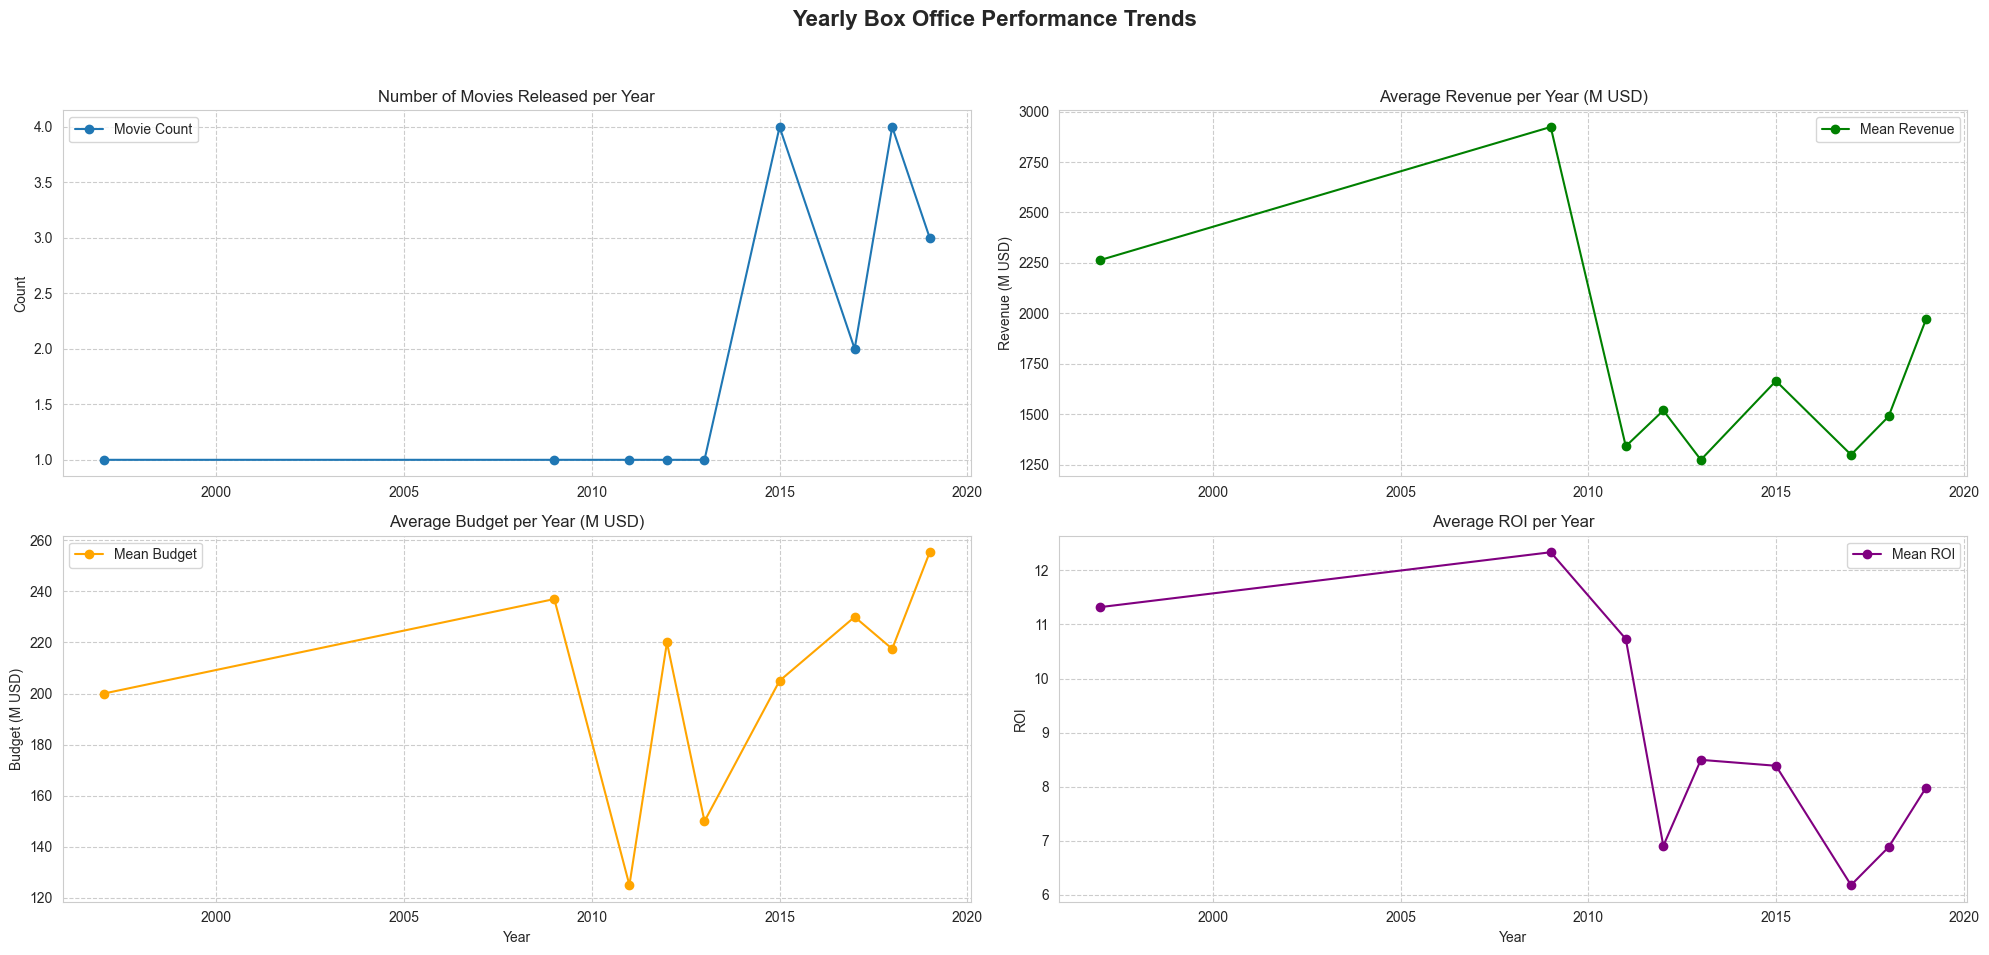

In [25]:
plot_yearly_trends(pdf_yearly)

Visualization: median ROI by genre.

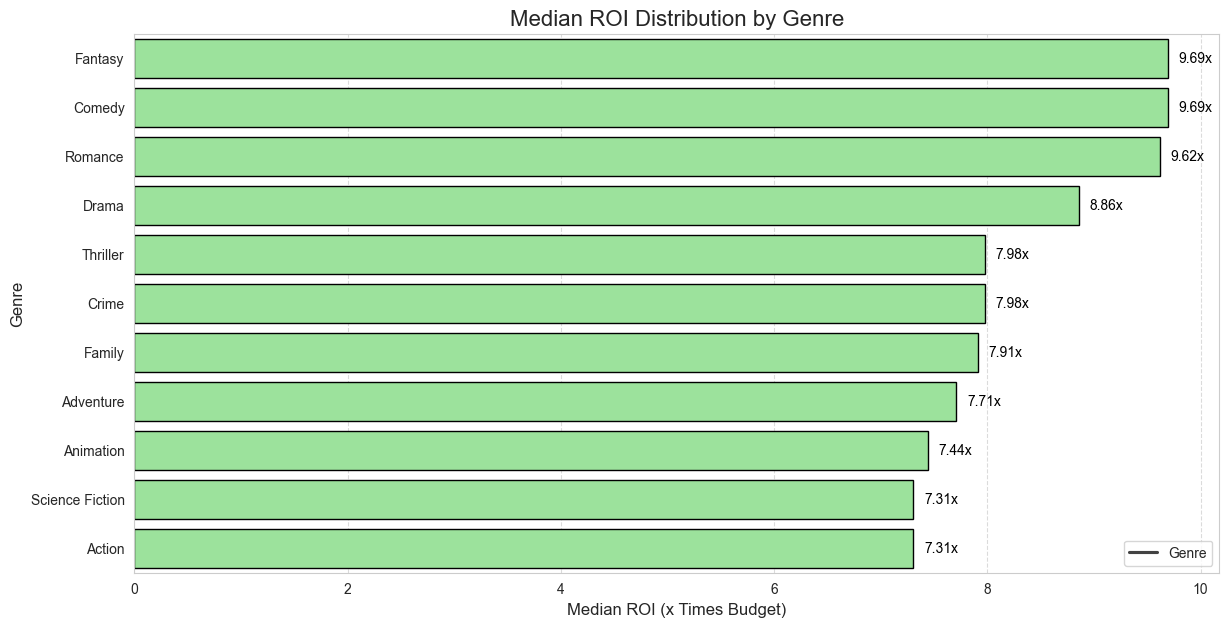

In [48]:
plot_genre_roi(pdf_genre)

Visualization: scatter of revenue vs budget to identify blockbusters and flops.

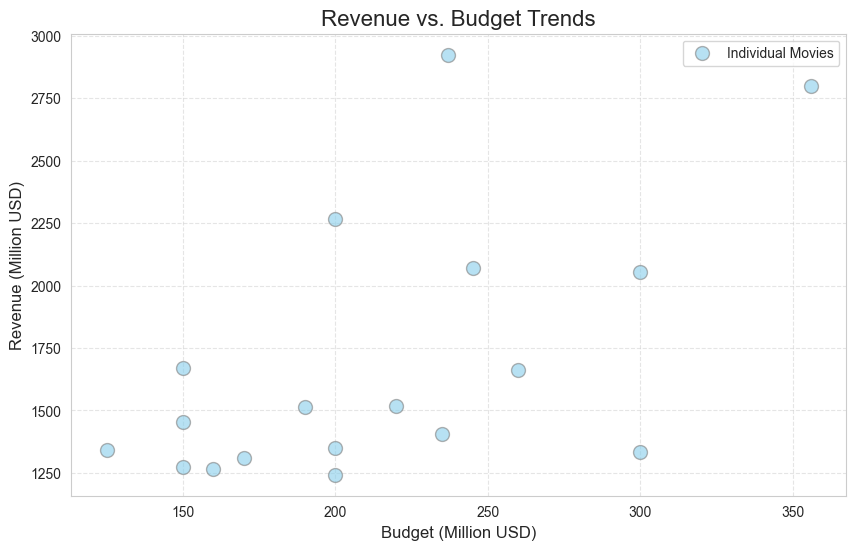

In [27]:
plot_revenue_vs_budget(pdf_scatter)

Visualization: compare franchise and standalone performance.

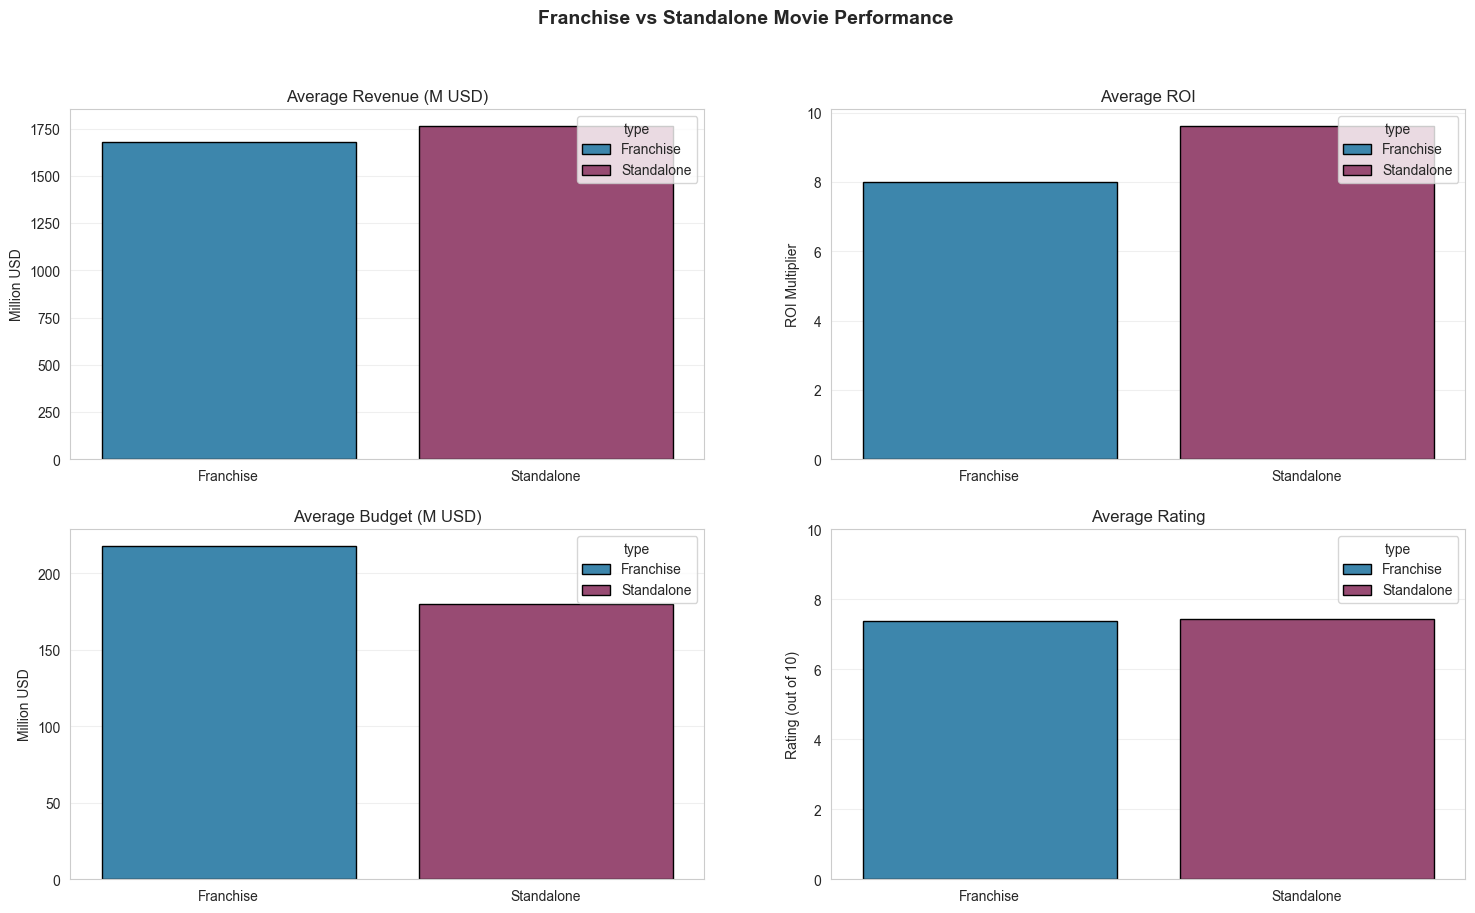

In [43]:
plot_franchise_comparison(pdf_franchise)

Visualization: popularity versus average rating scatter.

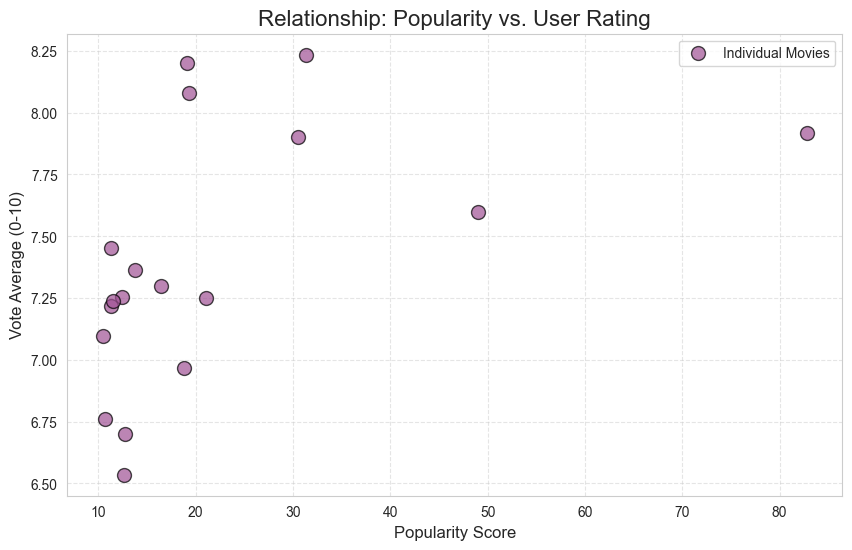

In [29]:
plot_popularity_vs_rating(pdf_scatter)